In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import eqmarl

In [57]:
import gymnasium as gym
import minigrid # Must import minigrid after gymnasium to register the environments properly.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [58]:
def generate_model_actor_classical_shared_mdp(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model

def generate_model_critic_classical_joint_mdp_central(n_agents: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()] # Flatten all inputs.
    layers += [keras.layers.Dense(u, activation=activation) for u in units] # Central branch dense layers.
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [59]:
from eqmarl.layers import HybridPartiteVariationalEncodingPQC, RescaleWeighted
from eqmarl.ops import ParameterizedRotationLayer_RxRyRz
import cirq
import functools as ft

# def generate_model_MiniGrid_critic_quantum_central_mdp(
#     n_agents: int,
#     n_layers: int,
#     squash_activation: str = 'arctan', # linear, arctan/atan, tanh
#     beta: float = 1.0,
#     name: str = None,
#     ):
#     """Centralized variant of hybrid joint quantum critic for CoinGame.
#     """

#     # Shape of observables is already known for CoinGame2.
#     obs_shape = (7,7,3)

#     # Qubit dimension is pre-determined for CoinGame2 environment.
#     # Using `4` to match observable dimension.
#     d_qubits_per_agent = 4
#     d_qubits = d_qubits_per_agent * n_agents

#     # Create qubit list using qubit dimensions.
#     qubits = cirq.LineQubit.range(d_qubits)

#     # Observables is joint Pauli product across all qubits.
#     observables = [ft.reduce(lambda x,y: x*y, [cirq.Z(q) for q in qubits])]

#     # Define quantum layer.
#     qlayer = HybridVariationalEncodingPQC(
#         qubits=qubits, 
#         d_qubits=d_qubits,
#         n_layers=n_layers,
#         observables=observables,
#         squash_activation=squash_activation,
#         encoding_layer_cls=ParameterizedRotationLayer_RxRyRz,
#         )

#     model = keras.Sequential([
#             keras.Input(shape=(n_agents, *obs_shape), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
#             keras.Sequential([
#                 # keras.layers.Reshape((n_agents*obs_shape[0], *obs_shape[1:])), # Reshape to matrix grid.
#                 # keras.layers.Lambda(lambda x: map_CoinGame2_obs_to_encoded_vector(x)), # converts (n_agents*4,3,3) into (n_agents*4,3)
#                 keras.layers.Reshape((n_agents,-1)), # Flatten each agent's observations.
#                 keras.layers.LocallyConnected1D(d_qubits_per_agent * 3, kernel_size=1, activation='linear'), # Reduce last feature dimension to (n_agents,d_qubits,3), use local dense units only to separate agents.
#                 keras.layers.Reshape((n_agents*d_qubits_per_agent,3)),
#                 ], name="input-preprocess"),
#             qlayer,
#             keras.Sequential([
#                 RescaleWeighted(len(observables)),
#                 keras.layers.Lambda(lambda x: x * beta),
#                 ], name='observables-value')
#         ], name=name)
#     return model


def generate_model_MiniGrid_critic_quantum_nnreduce_partite_pomdp(
    d_qubits: int,
    # keepdims: list[int],
    n_agents: int,
    n_layers: int,
    beta: float = 1.0,
    squash_activation: str = 'arctan', # linear, arctan/atan, tanh
    name: str = None,
    nn_activation: str = 'linear',
    trainable_w_enc: bool = True,
    input_entanglement: bool = True, # Flag to enable input entanglement (defaults to True).
    input_entanglement_type: bool = 'phi+', # ['phi+', 'phi-', 'psi+', 'psi-']
    ):
    """eQMARL variant of hybrid joint quantum critic for CoinGame2.
    """

    # Shape of observables is already known for CoinGame2.
    obs_shape = (7,7,3)

    # Create qubit list using qubit dimensions.
    qubits = cirq.LineQubit.range(n_agents * d_qubits)

    # Observables is joint Pauli product across all qubits.
    observables = [ft.reduce(lambda x,y: x*y, [cirq.Z(q) for q in qubits])]

    # Define quantum layer.
    qlayer = HybridPartiteVariationalEncodingPQC(
        qubits=qubits, 
        n_parts=n_agents,
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        squash_activation=squash_activation,
        encoding_layer_cls=ParameterizedRotationLayer_RxRyRz, # Encoder uses 3 weights per qubit.
        trainable_w_enc=trainable_w_enc,
        input_entanglement=input_entanglement,
        input_entanglement_type=input_entanglement_type,
        )

    model = keras.Sequential([
            keras.Input(shape=(n_agents, *obs_shape), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            # keras.Sequential([
            #     keras.layers.Reshape((n_agents, *obs_shape)), # Reshape to matrix grid.
            #     ], name="input-preprocess"),
            keras.layers.Reshape((n_agents,-1)), # Convert (n_agents,3,3,3) to (n_agents,3,9).
            keras.layers.LocallyConnected1D(d_qubits * 3, kernel_size=1, activation=nn_activation), # Reduce last feature dimension to (n_agents,3,3), use local dense units only to separate agents.
            keras.layers.Reshape((n_agents,d_qubits,3)),
            qlayer,
            keras.Sequential([
                RescaleWeighted(len(observables)),
                keras.layers.Lambda(lambda x: x * beta),
                ], name='observables-value')
        ], name=name)
    return model

In [60]:
from minigrid.core.world_object import Goal
class StepRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.last_pos = None
        self.goal_position: tuple = None
        
    def step(self, action):
        # Take the given action.
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Compute slope to goal.
        slope = np.divide(
            self.goal_position[1] - self.unwrapped.agent_pos[1],
            self.goal_position[0] - self.unwrapped.agent_pos[0],
        )
        slope = np.arctan(slope) # Angle.
        # print(f"{slope=}, {np.arctan(slope)=}")

        # # Give a negative reward for standing still.
        # if not terminated and self.last_pos is not None and self.unwrapped.agent_pos == self.last_pos:
        #     # print(f"matched pos")
        #     reward = -2.
        # Give a negative reward for each step.
        if not terminated and reward == 0:
                # reward = +1. * 1./slope
                # reward = +1.
                reward = -1.
        # If we're terminating, then scale the reward by 100.
        elif terminated:
            reward = reward * 100.
            
        self.last_pos = self.unwrapped.agent_pos
        # print(f"{self.unwrapped.agent_pos=}")

        return obs, reward, terminated, truncated, info
    
    def reset(self, *args, **kwargs):
        obs, info = self.env.reset(*args, **kwargs)

        if not self.goal_position:
            self.goal_position = [
                x for x, y in enumerate(self.unwrapped.grid.grid) if isinstance(y, Goal)
            ]
            # in case there are multiple goals , needs to be handled for other env types
            if len(self.goal_position) >= 1:
                self.goal_position = (
                    int(self.goal_position[0] / self.unwrapped.height),
                    self.goal_position[0] % self.unwrapped.width,
                )
        
        # print(f"{self.goal_position=}, {self.unwrapped.agent_pos=}")

        return obs, info

In [ ]:
import minigrid.wrappers


n_agents = 2
n_actions = 3 # 0=left, 1=right, 2=forward.
# env_id = "MiniGrid-LavaGapS5-v0"
env_id = "MiniGrid-Empty-5x5-v0"
# env_id = "MiniGrid-Empty-8x8-v0"
max_steps_per_episode = 50
env_vec = gym.vector.make(env_id, num_envs=n_agents, wrappers=[
    # minigrid.wrappers.ActionBonus,
    # minigrid.wrappers.PositionBonus,
    # minigrid.wrappers.FullyObsWrapper,
    minigrid.wrappers.ImgObsWrapper,
    StepRewardWrapper,
    minigrid.wrappers.ActionBonus,
    # lambda env: minigrid.wrappers.NoDeath(env, no_death_types=('lava',), death_cost=-1.),
    # gym.RewardWrapper,
], render_mode="rgb_array", max_steps=max_steps_per_episode)
obs_shape = env_vec.observation_space.shape[1:]
obs_shape

(7, 7, 3)

In [62]:
# units = [12]
# units = [48, 24, 12]
# units = [32]
units = [100]
# learning_rate = 1.0e-3
# learning_rate = 1.0e-2 # Causes action probabilities to go to NaN.
learning_rate = 1.0e-4 
model_actor = generate_model_actor_classical_shared_mdp(
    n_actions=n_actions,
    units=units,
    name='qfctde-actor',
)
model_actor.build([None, *obs_shape])
optimizer_actor = keras.optimizers.Adam(learning_rate=learning_rate)
model_critic = generate_model_MiniGrid_critic_quantum_nnreduce_partite_pomdp(
    d_qubits=4,
    n_agents=n_agents,
    n_layers=5,
    squash_activation='arctan', # linear, arctan/atan, tanh
    name='eqmarl-critic',
    nn_activation='linear',
    trainable_w_enc=False,
    input_entanglement=True, # Flag to enable input entanglement (defaults to True).
    input_entanglement_type='psi+', # ['phi+', 'phi-', 'psi+', 'psi-']
    )
model_critic.build([None, n_agents, *obs_shape])
optimizer_critic = [
    keras.optimizers.Adam(learning_rate=1.0e-3), # dense kernel
    keras.optimizers.Adam(learning_rate=1.0e-3), # dense bias
    keras.optimizers.Adam(learning_rate=1.0e-2), # w_var
    # keras.optimizers.Adam(learning_rate=1.0e-2), # w_enc
    keras.optimizers.Adam(learning_rate=1.0e-1), # obs_weights
]

model_actor.summary()
model_critic.summary()

Model: "qfctde-actor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 147)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               14800     
                                                                 
 policy (Dense)              (None, 3)                 303       
                                                                 
Total params: 15,103
Trainable params: 15,103
Non-trainable params: 0
_________________________________________________________________
Model: "eqmarl-critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 2, 147)            0         
                                                                 
 locally_connected1d_5 (Loc

In [63]:
algo = eqmarl.algorithms.MAA2C(
    env=env_vec,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=0.99,
    # gamma=0.95,
    alpha=0.001,
    # alpha=0.01,
    # alpha=0.1,
    # epsilon=0.1,
    # epsilon=0.3,
    # epsilon=0.4,
    )

In [64]:
n_episodes = 1000
reward_history, metrics_history = algo.train(
    n_episodes=n_episodes,
    max_steps_per_episode=max_steps_per_episode,
)

Training for 1000 episodes, press 'Ctrl+C' to terminate early
Episode 21:   2%|▏         | 21/1000 [00:30<23:06,  1.42s/episode, episode_reward=[-42.80839551 -39.69069444]]

/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_21534/2047830163.py:13: RuntimeWarning: divide by zero encountered in divide
/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_21534/2047830163.py:13: RuntimeWarning: divide by zero encountered in divide


Episode 22:   2%|▏         | 22/1000 [00:31<23:09,  1.42s/episode, episode_reward=[-33.59033315 -36.07315619]]

/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_21534/2047830163.py:13: RuntimeWarning: invalid value encountered in divide


Episode 31:   3%|▎         | 31/1000 [00:44<23:08,  1.43s/episode, episode_reward=[-39.19367828 -39.31158104]]

/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_21534/2047830163.py:13: RuntimeWarning: invalid value encountered in divide


Episode 1000: 100%|██████████| 1000/1000 [16:17<00:00,  1.02episode/s, episode_reward=[-49.67167907 -49.67055859]]


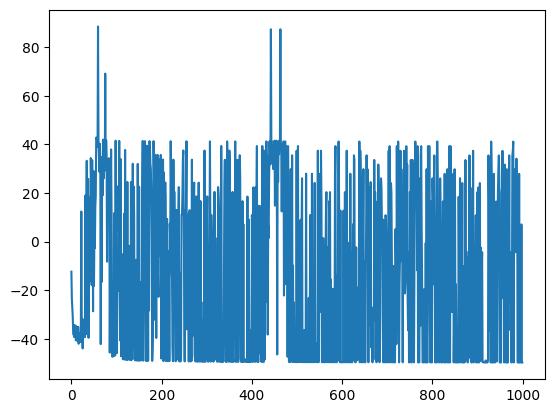

In [65]:
y = np.mean(reward_history, axis=1)
x = np.arange(len(y))
plt.plot(x, y)

In [66]:
from IPython.display import HTML
import matplotlib.animation as animation

def animate(imgs: list, type='js'): # 'js' or 'html'

    # Create figure and axes
    fig, ax = plt.subplots()

    def _animate(i):
        ax.clear()
        ax.imshow(imgs[i])

    anim = animation.FuncAnimation(fig, _animate, frames=len(imgs), interval=200)

    # Convert the animation to HTML5 video
    # HTML(anim.to_html5_video())
    if type == 'js':
        return HTML(anim.to_jshtml())
    else:
        return HTML(anim.to_html5_video())

In [67]:
def run(env, model_actor):
    actions = []
    rewards = []
    imgs = []
    # obs, info = env.reset(seed=42)
    s, info = env.reset()
    imgs.append(env.render())
    for t in range(max_steps_per_episode):
        s = tf.convert_to_tensor(s)
        s = tf.reshape(s, (-1, *s.shape))
        # print(f"{s.shape=}")

        action_probs = model_actor(s)
        
        # Sample action from estimated probability distribution.
        action = np.random.choice(action_probs.shape[-1], p=np.squeeze(action_probs))
        
        s, reward, terminated, truncated, info  = env.step(action)
        actions.append(action)
        rewards.append(reward)
        
        img = env.render()
        imgs.append(img)
        
        # print(f"{t=}, {reward=}, {action=}, {terminated=}")
        
        if terminated:
            break
    return imgs, actions, rewards

In [68]:
env = gym.make(env_id, render_mode="rgb_array")
env = minigrid.wrappers.ImgObsWrapper(env)
env = StepRewardWrapper(env)
imgs, _, _ = run(env, model_actor)
print(f"{len(imgs)-1} steps")

/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_21534/2047830163.py:13: RuntimeWarning: divide by zero encountered in divide
  slope = np.divide(
/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_21534/2047830163.py:13: RuntimeWarning: invalid value encountered in divide
  slope = np.divide(


9 steps


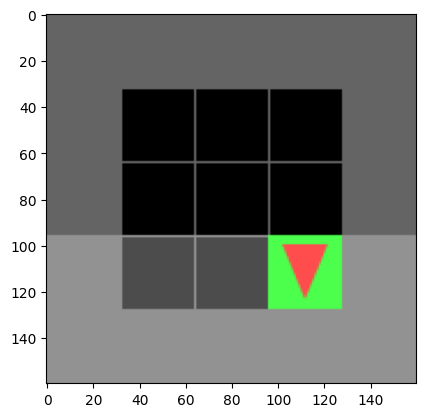

In [69]:
animate(imgs, type='js')

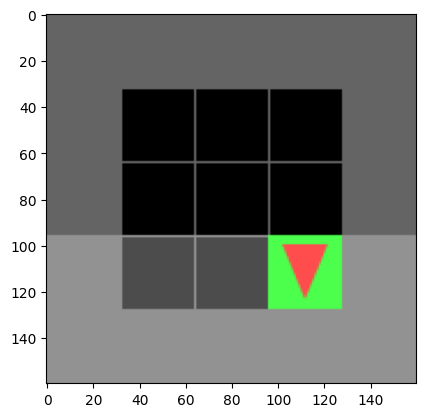

In [70]:
animate(imgs, type='html')